#### **Phase I**

#### 1. Problem & Target

#### feature說明
* age: 年齡範圍(以區間表示)
* menopause: 絕經情況
* tumor-size: 腫瘤大小
* inv-nodes: 受侵淋巴结数(以範圍表示)
* node-caps: 有無結節冒
* deg-malig: 惡性腫瘤程度
* breast: 腫瘤位置
* breast-quad: 腫塊所在象限
* irradiat: 是否放療
* Class: 是否有breast cancer?

#### 2. dataset

In [3]:
## load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from my_template import tot_exec_time, added_section_separate_line
from my_template import visualize_countplot
from my_template import remove_duplicate_rows, detect_column_only_single_value, detect_have_null_value, remove_null_value
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [4]:
## load dataset
names = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat', 'Class']
df = pd.read_csv('./dataset/breast-cancer.csv', names=names)
data = df.values

In [5]:
## summarize data
print(f"dataset head: \n{df.head()}")
added_section_separate_line()
print(f"dataset shape: {df.shape}")
added_section_separate_line()
pd.set_option('precision', 1)
print(f"dataset description: \n{df.describe()}")

dataset head: 
       age  menopause tumor-size inv-nodes node-caps deg-malig   breast  \
0  '40-49'  'premeno'    '15-19'     '0-2'     'yes'       '3'  'right'   
1  '50-59'     'ge40'    '15-19'     '0-2'      'no'       '1'  'right'   
2  '50-59'     'ge40'    '35-39'     '0-2'      'no'       '2'   'left'   
3  '40-49'  'premeno'    '35-39'     '0-2'     'yes'       '3'  'right'   
4  '40-49'  'premeno'    '30-34'     '3-5'     'yes'       '2'   'left'   

  breast-quad irradiat                   Class  
0   'left_up'     'no'     'recurrence-events'  
1   'central'     'no'  'no-recurrence-events'  
2  'left_low'     'no'     'recurrence-events'  
3  'left_low'    'yes'  'no-recurrence-events'  
4  'right_up'     'no'     'recurrence-events'  
------------------------------
dataset shape: (286, 10)
------------------------------
dataset description: 
            age  menopause tumor-size inv-nodes node-caps deg-malig  breast  \
count       286        286        286       286     

* 所有feature都是category
* target為二元分類問題

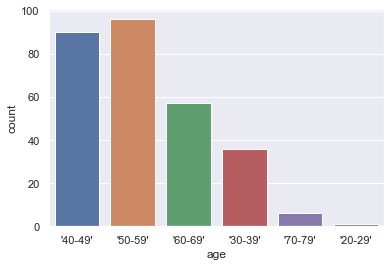

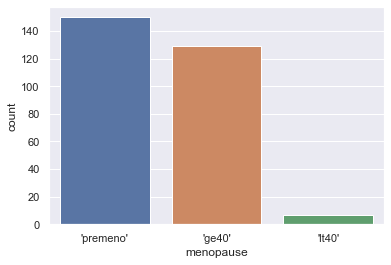

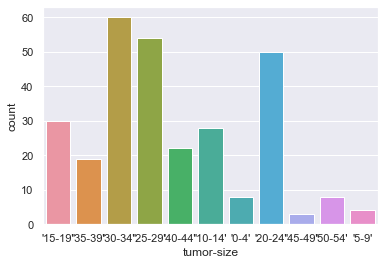

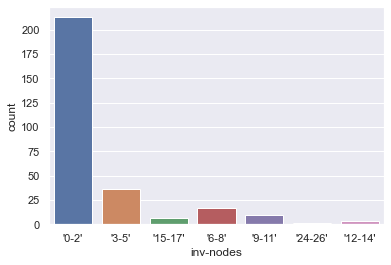

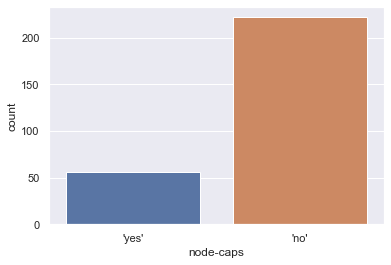

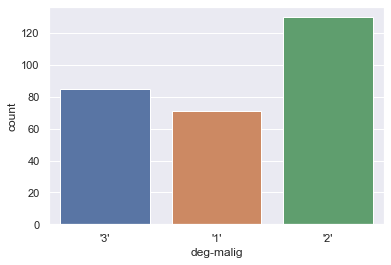

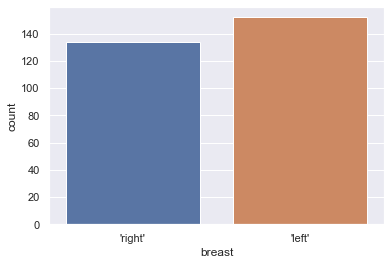

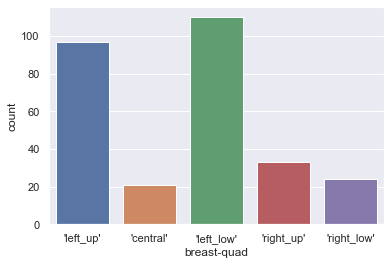

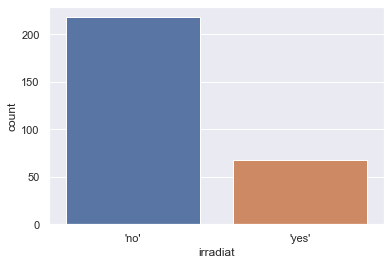

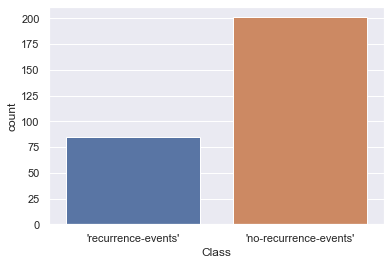

In [6]:
## data visualization
sns.set_theme(style="darkgrid")
visualize_countplot(df, df.columns)

#### **Phase II** (Round 0)

#### 3. data preprocessing

In [5]:
## data cleaning - remove duplicate
print(f"Origin shape: {df.shape}")
remove_duplicate_rows(df)
print(f"New shape: {df.shape}")

Origin shape: (286, 10)
         age  menopause tumor-size inv-nodes node-caps deg-malig   breast  \
17   '60-69'     'ge40'    '15-19'     '0-2'      'no'       '2'  'right'   
27   '40-49'  'premeno'    '10-14'     '0-2'      'no'       '1'  'right'   
44   '30-39'  'premeno'    '15-19'     '0-2'      'no'       '1'   'left'   
65   '50-59'     'ge40'    '15-19'     '0-2'      'no'       '1'  'right'   
117  '60-69'     'ge40'    '10-14'     '0-2'      'no'       '1'   'left'   
178  '40-49'  'premeno'    '25-29'     '0-2'      'no'       '2'  'right'   
190  '50-59'  'premeno'    '25-29'     '0-2'      'no'       '2'   'left'   
214  '40-49'  'premeno'    '20-24'     '0-2'      'no'       '2'  'right'   
217  '50-59'  'premeno'    '25-29'     '0-2'      'no'       '2'   'left'   
221  '50-59'     'ge40'    '20-24'     '0-2'      'no'       '3'   'left'   
239  '50-59'     'ge40'    '40-44'     '6-8'     'yes'       '3'   'left'   
245  '60-69'     'ge40'    '15-19'     '0-2'      'n

* 觀測有14條duplicate data，予以刪除

In [6]:
## data cleaning - data detection to remove
detect_column_only_single_value(df)
added_section_separate_line()
detect_have_null_value(df)
added_section_separate_line()
df = remove_null_value(df)

Record columns to delete (only single value): []
------------------------------
There are null values in dataframe: 
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
Class          0
dtype: int64
------------------------------
After remove null values: 
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64


In [7]:
## data cleaning - remove some particular condition
df = df[df['age']!="'20-29'"]

* 因為data在age只有一筆20-29歲的資料，數量太少而沒有參考性，故刪除

#### 4. model & validation

In [8]:
scoring = 'accuracy'
seed = 87

In [9]:
## data transform - encoding categories features to numeric
data = df.values
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
validation_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train)
X_train = ordinal_encoder.transform(X_train)
X_test = ordinal_encoder.transform(X_test)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
print(f"Input: {X_train.shape}")
print(X_train[:5, :])
print(f"Output: {y_train.shape}")
print(y_train[:5])

Input: (209, 9)
[[1. 0. 4. 0. 0. 1. 0. 1. 0.]
 [1. 2. 5. 0. 0. 1. 1. 4. 1.]
 [1. 2. 5. 2. 1. 2. 0. 1. 0.]
 [3. 0. 2. 0. 0. 0. 0. 3. 0.]
 [1. 2. 6. 0. 0. 1. 1. 4. 0.]]
Output: (209,)
[0 0 1 0 0]


>LR 0.740 (0.072)
>KNN 0.665 (0.075)
>DC 0.605 (0.096)
>RF 0.697 (0.085)
>GBM 0.689 (0.081)
>LDA 0.739 (0.079)
>SVM 0.713 (0.068)
>PER 0.657 (0.115)


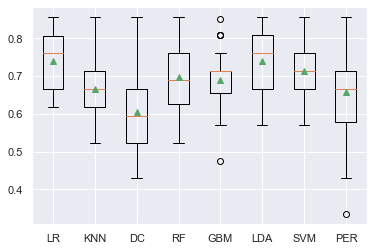

In [10]:
# build model
models = dict()
models['LR'] = Pipeline(steps=[('m', LogisticRegression())])
models['KNN'] = Pipeline(steps=[('m', KNeighborsClassifier())])
models['DC'] = Pipeline(steps=[('m', DecisionTreeClassifier())])
models['RF'] = Pipeline(steps=[('m', RandomForestClassifier())])
models['GBM'] = Pipeline(steps=[('m', GradientBoostingClassifier())])
models['LDA'] = Pipeline(steps=[('m', LinearDiscriminantAnalysis())])
models['SVM'] = Pipeline(steps=[('m', SVC(gamma='auto'))])
models['PER'] = Pipeline(steps=[('m', Perceptron())])

# train model
results, names = list(), list()
for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    results.append(scores)
    names.append(name)
    print(f">{name} {np.mean(scores):.3f} ({np.std(scores):.3f})")
# plot
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

* 小結:
    * 使用OrdinalEncoder對所有feature做encode，使用LabelEncoder對target做encode
    * 使用RepeatedStratifiedKFold對model做訓練
    * 以accuracy為驗證指標得出的結果為Logistic Regression為最佳，但74% accuracy仍不夠好

#### **Phase II** (Round 1：使用One-hot encoding)

In [11]:
## data transform - encoding categories features to numeric
data = df.values
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
validation_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X_train)
X_train = onehot_encoder.transform(X_train)
X_test = onehot_encoder.transform(X_test)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
print(f"Input: {X_train.shape}")
print(X_train[:5, :])
print(f"Output: {y_train.shape}")
print(y_train[:5])

Input: (209, 40)
[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]]
Output: (209,)
[0 0 1 0 0]


In [12]:
scoring = 'accuracy'
seed = 87

>LR 0.739 (0.077)
>KNN 0.719 (0.067)
>DC 0.609 (0.084)
>RF 0.727 (0.069)
>GBM 0.686 (0.091)
>LDA 0.717 (0.084)
>SVM 0.702 (0.023)
>PER 0.643 (0.114)


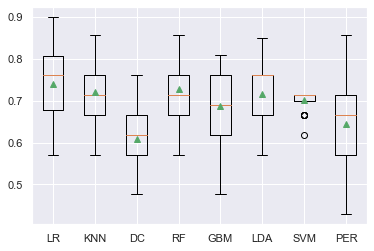

In [13]:
# build model
models = dict()
models['LR'] = Pipeline(steps=[('m', LogisticRegression())])
models['KNN'] = Pipeline(steps=[('m', KNeighborsClassifier())])
models['DC'] = Pipeline(steps=[('m', DecisionTreeClassifier())])
models['RF'] = Pipeline(steps=[('m', RandomForestClassifier())])
models['GBM'] = Pipeline(steps=[('m', GradientBoostingClassifier())])
models['LDA'] = Pipeline(steps=[('m', LinearDiscriminantAnalysis())])
models['SVM'] = Pipeline(steps=[('m', SVC(gamma='auto'))])
models['PER'] = Pipeline(steps=[('m', Perceptron())])
# train model
results, names = list(), list()
for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    results.append(scores)
    names.append(name)
    print(f">{name} {np.mean(scores):.3f} ({np.std(scores):.3f})")
# plot
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

* 小結：
    * 對feature使用不同encode方式調整似乎沒有太大幫助，可考慮對feature做selection

#### **Phase II** (Round 2：使用RFE做feature selection + OrdinalEncoder)

In [14]:
## data transform - encoding categories features to numeric
data = df.values
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
validation_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train)
X_train = ordinal_encoder.transform(X_train)
X_test = ordinal_encoder.transform(X_test)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
# parameter setting
scoring = 'accuracy'
seed = 87
n_features_to_select = 6
# build model
models = dict()
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
models['LR'] = Pipeline(steps=[('s', rfe), ('m', LogisticRegression())])
rfe = RFE(estimator=KNeighborsClassifier(), n_features_to_select=5)
models['KNN'] = Pipeline(steps=[('s', rfe), ('m', KNeighborsClassifier())])
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
models['DC'] = Pipeline(steps=[('s', rfe), ('m', DecisionTreeClassifier())])
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
models['RF'] = Pipeline(steps=[('s', rfe), ('m', RandomForestClassifier())])
rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
models['GBM'] = Pipeline(steps=[('s', rfe), ('m', GradientBoostingClassifier())])
rfe = RFE(estimator=LinearDiscriminantAnalysis(), n_features_to_select=5)
models['LDA'] = Pipeline(steps=[('s', rfe), ('m', LinearDiscriminantAnalysis())])
rfe = RFE(estimator=SVC(gamma='auto'), n_features_to_select=5)
models['SVM'] = Pipeline(steps=[('s', rfe), ('m', SVC(gamma='auto'))])
rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
models['PER'] = Pipeline(steps=[('s', rfe), ('m', Perceptron())])
# train model
results, names = list(), list()
for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    results.append(scores)
    names.append(name)
    print(f">{name} {np.mean(scores):.3f} ({np.std(scores):.3f})")

>LR 0.731 (0.079)
>KNN nan (nan)
>DC 0.597 (0.108)
>RF 0.641 (0.086)
>GBM 0.681 (0.077)
>LDA 0.727 (0.085)
>SVM nan (nan)
>PER 0.652 (0.108)


* 小結：
    * 使用RFE做feature selection，feature selected number為6時仍沒有太大進步，或需考量測試不同的參數

#### **Phase II** (Round 3：Logistic Regression + RFE(feature selection) + OrdinalEncoder做n_features_to_select超參數確認

In [15]:
# parameter setting
scoring = 'accuracy'
seed = 87
## data transform - encoding categories features to numeric
data = df.values
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
validation_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train)
X_train = ordinal_encoder.transform(X_train)
X_test = ordinal_encoder.transform(X_test)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
# build model
pipelines = RFE(estimator=LogisticRegression())
##pipelines = Pipeline(steps=[('s', rfe), ('m', LogisticRegression())])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=87)
# define gridsearch
param_dict = {
    "n_features_to_select": range(4, 9, 1)
}
search = GridSearchCV(pipelines, param_dict, scoring='accuracy', cv=cv, n_jobs=-1)
# train
results = search.fit(X_train, y_train)
# summarize best
print(f"Best Mean Accuracy: {results.best_score_:.3f}")
print(f"Best Config: {results.best_params_}")

Best Mean Accuracy: 0.742
Best Config: {'n_features_to_select': 8}


In [16]:
# 利用最佳的RFE n_features_to_select超參數進行訓練驗證
n_features_to_select = 8
models = dict()
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=n_features_to_select)
models['LR'] = Pipeline(steps=[('s', rfe), ('m', LogisticRegression())])
rfe = RFE(estimator=KNeighborsClassifier(), n_features_to_select=n_features_to_select)
models['KNN'] = Pipeline(steps=[('s', rfe), ('m', KNeighborsClassifier())])
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features_to_select)
models['DC'] = Pipeline(steps=[('s', rfe), ('m', DecisionTreeClassifier())])
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features_to_select)
models['RF'] = Pipeline(steps=[('s', rfe), ('m', RandomForestClassifier())])
rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=n_features_to_select)
models['GBM'] = Pipeline(steps=[('s', rfe), ('m', GradientBoostingClassifier())])
rfe = RFE(estimator=LinearDiscriminantAnalysis(), n_features_to_select=n_features_to_select)
models['LDA'] = Pipeline(steps=[('s', rfe), ('m', LinearDiscriminantAnalysis())])
rfe = RFE(estimator=SVC(gamma='auto'), n_features_to_select=n_features_to_select)
models['SVM'] = Pipeline(steps=[('s', rfe), ('m', SVC(gamma='auto'))])
rfe = RFE(estimator=Perceptron(), n_features_to_select=n_features_to_select)
models['PER'] = Pipeline(steps=[('s', rfe), ('m', Perceptron())])
# train model
results, names = list(), list()
for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    results.append(scores)
    names.append(name)
    print(f">{name} {np.mean(scores):.3f} ({np.std(scores):.3f})")

>LR 0.742 (0.071)
>KNN nan (nan)
>DC 0.603 (0.116)
>RF 0.686 (0.079)
>GBM 0.662 (0.092)
>LDA 0.739 (0.076)
>SVM nan (nan)
>PER 0.628 (0.143)


* 小結：
    * 使用GridSearchCV針對RFE找出n_features_to_select超參數=8
    * 利用使用的超參數仍無法得到比較好的結果

* 結論：
    * 依目前測試不同feature encode、feature selection，以及不同的algorithms來比較，目前表現最好的是logistic regression

#### **Phase III**

#### 5. prediction

In [19]:
# parameter setting
scoring = 'accuracy'
seed = 87
## data transform - encoding categories features to numeric
data = df.values
X = data[:, :-1].astype(str)
y = data[:, -1].astype(str)
validation_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train)
X_train = ordinal_encoder.transform(X_train)
X_test = ordinal_encoder.transform(X_test)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"accuracy score: {100*accuracy_score(y_test, y_pred):.3f}%")
added_section_separate_line()
print(f"confusion matric: \n{confusion_matrix(y_test, y_pred)}")
added_section_separate_line()
print(f"classification report: \n{classification_report(y_test, y_pred)}")

accuracy score: 81.132%
------------------------------
confusion matric: 
[[36  2]
 [ 8  7]]
------------------------------
classification report: 
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        38
           1       0.78      0.47      0.58        15

    accuracy                           0.81        53
   macro avg       0.80      0.71      0.73        53
weighted avg       0.81      0.81      0.79        53



* 這邊使用訓練過程中較佳的模型logistic regression進行訓練，不做feature selection，使用ordinal encode與label encode對feature進行編碼，得到的結果
* 指標觀察accuracy、precision、recall與f1-score表現皆尚可，後續仍有進步空間
* 可利用與baseline model的比較來確認進步幅度